### Object Material Type (OMT) Classifier, based on Google's Mobilenetv3 Model
References:
- https://blog.research.google/2019/11/introducing-next-generation-on-device.html
- https://www.kaggle.com/models/google/mobilenet-v3/frameworks/tensorFlow2
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.tensorflow.org/tutorials/load_data/images
- https://github.com/CHOOSLA/Recycle_Classification_MobileNetV3

Found 24235 files belonging to 5 classes.
Using 19388 files for training.
Found 24235 files belonging to 5 classes.
Using 4847 files for validation.


2024-03-19 18:14:04.157068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 18:14:05.487914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


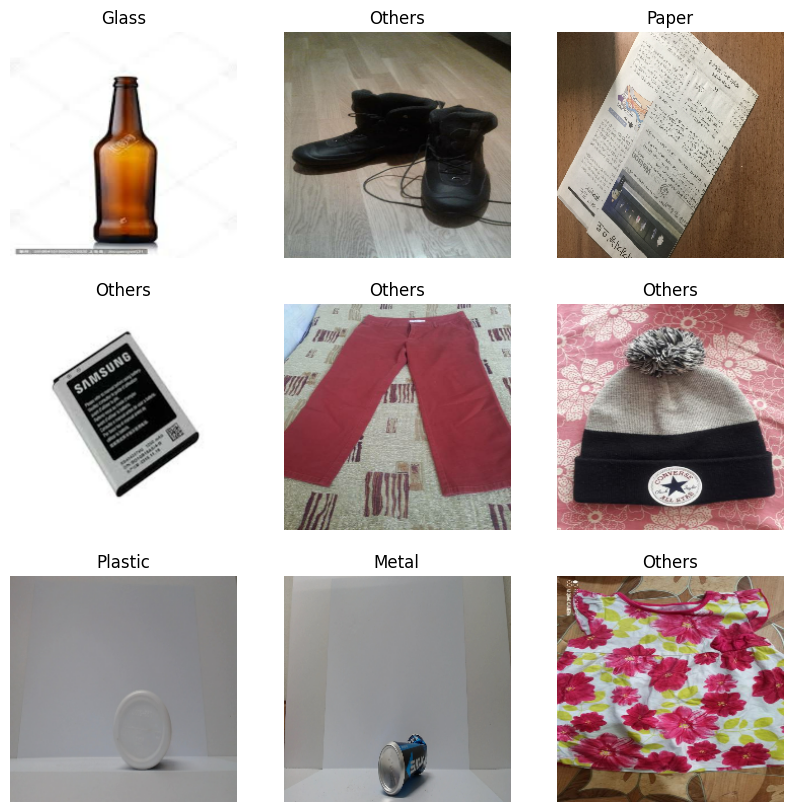

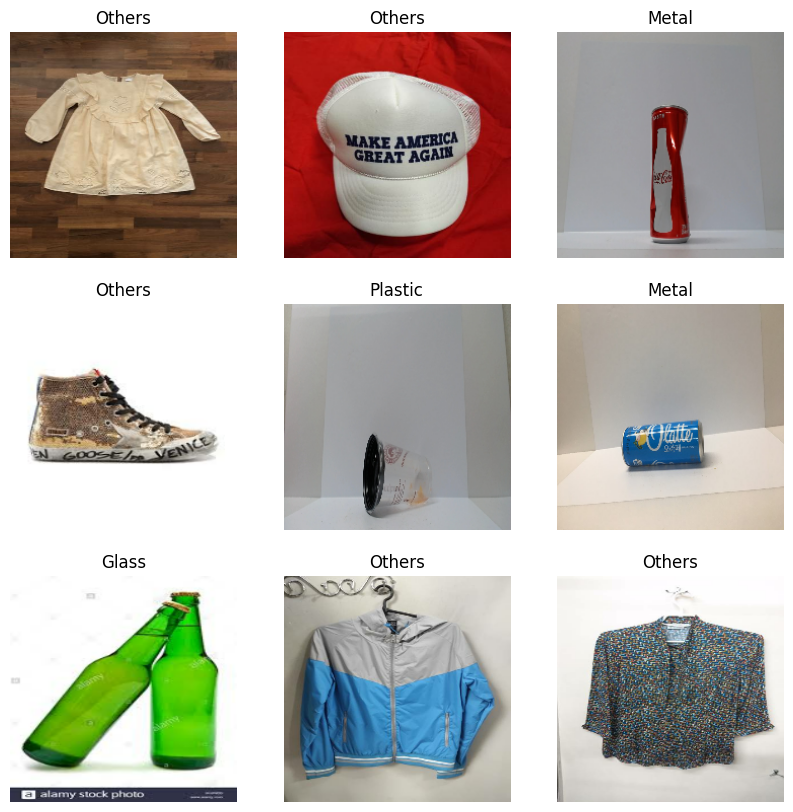

In [2]:
from utils import *

""" Dataset Preparations """
# Parameters
img_batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)
img_shape = img_size + (3,)

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=19032024,
  image_size=(img_height, img_width),
  batch_size=img_batch_size)

# Validation (test) dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=19032024,
  image_size=(img_height, img_width),
  batch_size=img_batch_size)

# Get class names
class_names = train_ds.class_names
class_names = val_ds.class_names

# Enable buffered prefetching to overlap data preprocessing and model execution during training, to speed up access to dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Normalise image tensors' RGB channel values from [0, 255] to required [-1, 1] values used by Mobilenet (use preprocess_input function provided by the model instead!)
# normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
# normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Preview datasets
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [3]:
# Initialise base model
base_model = tf.keras.applications.MobileNetV3Small(input_shape=img_shape, include_top=False, weights='imagenet')

# Freeze base model
base_model.trainable = False

""" Create classification head """
# Create NN layers
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),tf.keras.layers.RandomRotation(0.2),tf.keras.layers.RandomZoom(0.2)])
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Create classifier
inputs = keras.Input(shape=img_shape)

# Preprocessing layers
x = data_augmentation(inputs)
x = preprocess_input(x)

# Base model layer, ensure that the model is running in inference mode
x = base_model(x, training=False) 

# Processing layers
x = global_average_layer(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x) # Dropout regularisation to prevent overfitting

# Dense classifier layer for multi-label classification
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)

# Create classification head
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [4]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,108,981 (11.86 MB)

 Trainable params: 2,168,837 (8.27 MB)

 Non-trainable params: 940,144 (3.59 MB)

In [5]:
# Train model
history = model.fit( train_ds, validation_data=val_ds, epochs=10)

# Export model
model.save(model_file)

# Export material class mapping
save_to_pickle(class_name_file, class_names)

Epoch 1/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 114s 181ms/step - accuracy: 0.7649 - loss: 0.6729 - val_accuracy: 0.8554 - val_loss: 0.4439
Epoch 2/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 119s 194ms/step - accuracy: 0.8831 - loss: 0.3447 - val_accuracy: 0.8882 - val_loss: 0.3079
Epoch 3/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 112s 183ms/step - accuracy: 0.9086 - loss: 0.2652 - val_accuracy: 0.9131 - val_loss: 0.2514
Epoch 4/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 110s 180ms/step - accuracy: 0.9214 - loss: 0.2308 - val_accuracy: 0.9004 - val_loss: 0.3129
Epoch 5/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 109s 178ms/step - accuracy: 0.9306 - loss: 0.1965 - val_accuracy: 0.9080 - val_loss: 0.2869
Epoch 6/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 109s 177ms/step - accuracy: 0.9401 - loss: 0.1769 - val_accuracy: 0.9202 - val_loss: 0.2633
Epoch 7/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 108s 177ms/step - accuracy: 0.9464 - loss: 0.1613 - val_accuracy: 0.9327 - val_loss: 0.1930
Epoch 8/10
606/606 ━━━━━━━━━━━━━━━━━━━━ 108s 177ms/step - accuracy: 0.9473 -

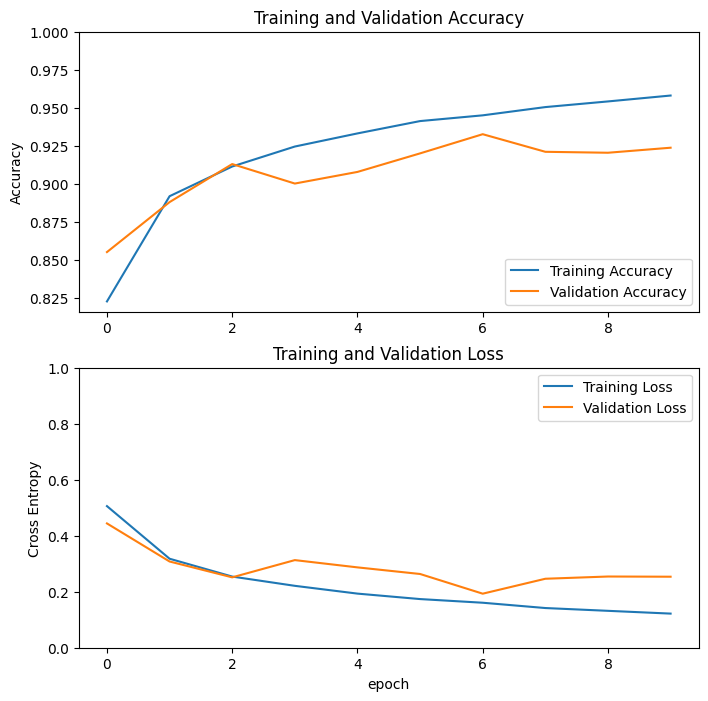

152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.9235 - loss: 0.2586
Test Accuracy : 0.9238704442977905
Test Loss : 0.2535827159881592


In [6]:
""" Preliminary Model Performance """
# View training metrics across epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(val_ds)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)

In [ ]:
""" Model Performance """
# Load the trained model
model = keras.models.load_model(model_file)

# Load class names
class_names = load_from_pickle(class_name_file)

# Load dataset
df_dataset = load_from_pickle(dataset_file)

# 80-20 Train-Test split
x_train, x_test, y_train, y_test = train_test_split(df_dataset['File'], df_dataset['Material Class'], test_size=0.2, stratify=df_dataset['Material Class'], random_state=1234)
y_train = y_train.map(material_class_mapping)
y_test = y_test.map(material_class_mapping)

# Initialise predictions
list_train_pred = []
list_test_pred = []
for image_path in x_train:
    list_train_pred.append(predict_class(image_path, model, class_names, (224, 224)))
for image_path in x_test:
    list_test_pred.append(predict_class(image_path, model, class_names, (224, 224)))

In [ ]:
# Get model's training performance
training_results = multi_class_metrics(list(y_train), list_train_pred)
accuracy = training_results['accuracy']
precision = training_results['precision']
recall = training_results['recall']
f1 = training_results['f1']
mcc = training_results['mcc']
kappa = training_results['kappa']
hamming_loss_val = training_results['hamming_loss_val']
cm = training_results['cm']
class_report = training_results['class_report']

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Cohen's Kappa:", kappa)
print("Hamming Loss:", hamming_loss_val, end='\n\n')
print("Confusion Matrix:\n", cm, end="\n\n")
print("Classification Report:\n", class_report, end="\n\n\n")

In [ ]:
# Get model's test performance
test_results = multi_class_metrics(list(y_train), list_train_pred)
accuracy = test_results['accuracy']
precision = test_results['precision']
recall = test_results['recall']
f1 = test_results['f1']
mcc = test_results['mcc']
kappa = test_results['kappa']
hamming_loss_val = training_results['hamming_loss_val']
cm = test_results['cm']
class_report = test_results['class_report']

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient (MCC):", mcc)
print("Cohen's Kappa:", kappa)
print("Hamming Loss:", hamming_loss_val, end='\n\n')
print("Confusion Matrix:\n", cm, end="\n\n")
print("Classification Report:\n", class_report, end="\n\n\n")